## Oscillons

In [90]:
%matplotlib inline

In [91]:
import os,sys
sys.path.append('./bubbles_codes/')
from plotting import *
from bubble_tools import *
from experiment import *
%run './bubbles_codes/plotting.py'
from itertools import chain
import operator as op
import pywt


<Figure size 640x480 with 0 Axes>

In [92]:
def get_bubble(exp_params, sim, crit_thresh, crit_rad):
    path2RESTsim  = rest_sim_location(*exp_params, sim)
    path2CLEANsim = clean_sim_location(*exp_params, sim)

    bubble = np.load(path2CLEANsim)[0]
    bubble = np.array([bubble[0]])
    totbeta = np.load(path2RESTsim)[-1]

  #  bubble = multiply_bubble(bubble, lightc, phieq, totbeta, normal, nLat)
    bubble = bubble[0]
  #  bubble = gaussian_filter(bubble, sigma=2, mode='nearest')

    tcen, xcen = find_nucleation_center(bubble, phieq, crit_thresh, crit_rad)
  #  bubble = bubble[max(tcen-nLat*2//3,0):tcen]
    tcen += 100
    if tcen-nLat < 0:
        return None, None
    bubble = bubble[tcen-nLat:tcen]
    mn = np.mean(bubble)
    bubble-= mn
    return bubble, mn

def get_not_bubble(exp_params, sim, crit_thresh, crit_rad):
    real, _ = get_realisation(nLat, sim, phieq, path2sim)
    bubble = real[0]
    nT, nN = np.shape(bubble)
    mombub = real[1]
    return bubble, mombub

def get_HT(array):  
    array = array - np.mean(array)
    w  = np.fft.fftfreq(len(array), d=1) * len(array)
    FD = np.fft.fft(array, axis=0)
    FD[w<=0.,:] = 0.
    FD[w>0.,:] *= 2.
    HD = np.fft.ifft(FD, axis=0)
    return np.abs(HD)

def get_4T(array):
    nT, nN = np.shape(array)
    tw = np.fft.fftfreq(nT, d=1) * nT
    xw = np.fft.fftfreq(nN, d=1) * nN

    tFD = np.fft.fft(array, axis=0)
    tFD[tw<0,:] = 0.
    tFD[tw>0,:]*= 2.
    tHD = np.fft.ifft(tFD, axis=0)

    xFD = np.fft.fft(array, axis=1)
    xFD[:,xw<0] = 0.
    xFD[:,xw>0]*= 2.
    xHD = np.fft.ifft(xFD, axis=1)

    lFD = np.fft.fft(tHD, axis=1)
    lFD[:,xw<0] = 0.
    lFD[:,xw>0]*= 2.
    lHD = np.fft.ifft(lFD, axis=1)

    rFD = np.fft.fft(xHD, axis=0)
    rFD[tw>0,:] = 0.
    rFD[tw<0,:]*= 2.
    rHD = np.fft.ifft(rFD, axis=0)
    return np.abs(tHD), np.abs(xHD), np.abs(lHD), np.abs(rHD)

def get_cummul_power(freqsT, freqsX, PST, PSX):
    # flat list of all frequencies where response is strong
    all_frqT = flatten_comprehension2(savefrqT)
    all_frqX = flatten_comprehension2(savefrqX)

    all_psT  = flatten_comprehension(savePST)
    all_psX  = flatten_comprehension(savePSX)

    # cut duplicates
    set_Tfreqs = np.sort(all_frqT)
    set_Xfreqs = np.sort(all_frqX)

    # add field responses to get relative importance of each mode
    set_Ttotamps = np.zeros(len(set_Tfreqs))
    for fi, frq in enumerate(set_Tfreqs):
        inds = np.argwhere(np.abs(all_frqT)==frq).flatten()
        set_Ttotamps[fi] = np.sum(all_psT[inds])

    # and in X
    set_Xtotamps = np.zeros(len(set_Xfreqs))
    for fi, frq in enumerate(set_Xfreqs):
        inds = np.argwhere(np.abs(all_frqX)==frq).flatten()
        set_Xtotamps[fi] = np.sum(all_psX[inds])
    return set_Tfreqs, set_Xfreqs, set_Ttotamps, set_Xtotamps

def get_osc_trajectory(array, extent):
    # find maximum value in array
    T, N = np.shape(array)
    flattened = chain.from_iterable(array)
    max_idx, max_val = max(enumerate(flattened), key=op.itemgetter(1))
    row = max_idx // N
    col = max_idx % N
#    print(array[row][col] == max_val, max_val, array[row][col], row, col)
#    ax[axis].plot(col, row, 'ro', ms=10)

    # use as starting point for oscillon trajectory
#    print(col, row)
    maxLine = []
    CCol = col
    for rr in range(row)[::-1]:
        if rr == row-1:
            col = CCol
        colmin = col - extent
        colmax = col + extent+1
        val = 0
        for cc in range(colmin, colmax):
            cc = cc%N
            if array[rr][cc] > val:
                val = array[rr][cc]
                col = cc
        maxLine.append(col)
    maxLine = maxLine[::-1]
    for rr in range(row, T):
        if rr == row:
            col = CCol
        colmin = col - extent
        colmax = col + extent+1
        val = 0
        for cc in range(colmin, colmax):
            cc = cc%N
            if array[rr][cc] > val:
                val = array[rr][cc]
                col = cc
        maxLine.append(col)
    return np.array(maxLine)

# average oscillon trajectories
def tolerant_mean(arrs):
    lens = np.array([len(i) for i in arrs])
  #  print(lens.tolist())
    arr  = np.zeros((len(lens), np.max(lens)))
    for ri, osc in enumerate(arrs):
        arr[ri, :len(osc)] = osc
    arr[arr == 0] = np.nan
    return np.nanmean(arr, axis=0), np.nanstd(arr, axis=0)

def tolerant_mean2d(arrs):
    lens = np.array([np.shape(i) for i in arrs])
    lens1, lens2 = lens[:,0], lens[:,1]

    arr  = np.zeros((len(arrs), np.max(lens1), np.max(lens2)))
    for ri, osc in enumerate(arrs):
        n1, n2 = np.shape(osc)
        arr[ri, :n1, :n2] = osc
    arr[arr == 0.] = np.nan
    return np.nanmean(arr, axis=0), np.nanstd(arr, axis=0)

def flatten_comprehension(matrix):
    return np.array([item for row in matrix for item in row])

def flatten_comprehension2(matrix):
    return np.array([np.abs(np.round(item,10)) for row in matrix for item in row])


In [93]:
tmp = 0
phi0, temp, lamb, sigmafld, minSim, maxSim, right_Vmax = get_model(tmp)
exp_params = np.asarray([nLat, lamb, phi0, temp])

simLists, notsimLists = [], []
for sim in range(minSim, maxSim):
    path2RESTsim = rest_sim_location(*exp_params, sim)
    if os.path.exists(path2RESTsim):
        path2CLEANsim = clean_sim_location(*exp_params, sim)
        if os.path.exists(path2CLEANsim):
            simLists.append(sim)
for sim in range(minSim, maxSim):
    path2sim = sim_location(*exp_params, sim)
    if os.path.exists(path2sim):
       # sizeSim = os.path.getsize(path2sim)
       # if sizeSim > bytesUNDECAYED/2:
        notsimLists.append(sim)
simLists = np.array(simLists)
notsimLists = np.array(notsimLists)[::5]


In [94]:
len(notsimLists)

800

In [95]:
crit_rad = 10
crit_thresh = right_Vmax.x + 4.*sigmafld
print(crit_thresh)

deltae = 25
print(deltae * dx * np.sqrt(m2(lamb)))

dk2ploit = 2.*np.pi/(nLat*dx) / np.sqrt(m2(lamb))


5.348981768243531
1.9301011109426147


In [96]:
saveData = False


In [97]:
if saveData:
    avPowSpec, avfieldvar, avmomvar = [], [], []
    for si, sim in enumerate(notsimLists):
        bubble, mombub = get_not_bubble(exp_params, sim, crit_thresh, crit_rad)

        avfieldvar.append(np.var(bubble, axis=1))
        avmomvar.append(np.var(mombub, axis=1))

        bubble = bubble - np.mean(bubble)
        avPowSpec.append(np.abs(np.fft.fft2(bubble))**2.)

    np.save('./data/average_PS_data_T'+str(temp)+'.npy', np.nanmean(avPowSpec, axis=0))
    np.save('./data/average_avfieldvar_data_T'+str(temp)+'.npy', np.nanmean(avfieldvar, axis=0))
    np.save('./data/average_avmomvar_data_T'+str(temp)+'.npy', np.nanmean(avmomvar, axis=0))

    oscillonData, NULLoscillonData, avPowSpecbubs = [], [], []
    for si, sim in enumerate(simLists):
        bubble, mn = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        try:
            nT, nN = np.shape(bubble)
            aHT = get_HT(bubble)
        except:
            continue

        maxln1 = get_osc_trajectory(aHT, extent=deltae)
        avOscillon = bubble[np.arange(nT), maxln1][::-1]
        maxln1-= nN//2

        oscillonData.append(np.array([sim, avOscillon, mn]))

        xrand = np.random.randint(0,nN-1)
        nullOscillon = bubble[np.arange(nT), xrand][::-1]

        NULLoscillonData.append(np.array([sim, nullOscillon, mn]))
        avPowSpecbubs.append(np.abs(np.fft.fft2(bubble))**2.)

    np.save('./data/oscillon_data.npy', oscillonData)
    np.save('./data/null_oscillon_data.npy', NULLoscillonData)
    np.save('./data/bubble_average_PS_data.npy', np.nanmean(avPowSpecbubs, axis=0))

    if not saveData:
        oscillonData = np.load('./data/oscillon_data.npy')
        NULLoscillonData = np.load('./data/null_oscillon_data.npy')

        simLists, oscillonAmp, means = oscillonData[:,0], oscillonData[:,1], oscillonData[:,2]
        NULLoscillonAmp = NULLoscillonData[:,1]

        oscillonFreqData, NULLoscillonFreqData = [], []
        for si, sim in enumerate(simLists):
            oscillon = oscillonAmp[si]
            mn = means[si]

            nT = len(oscillon)
            fft_oscillon = np.fft.fft(oscillon, norm='forward')
            freqs = np.fft.fftfreq(nT, d=1) * nT
            PS_oscillon = (np.conj(fft_oscillon)*fft_oscillon).real
            ind = np.argmax(PS_oscillon[freqs>0])

            oscillonFreqData.append(np.array([freqs, PS_oscillon, ind]))

            NULLoscillon = NULLoscillonAmp[si]
            fft_NULLoscillon = np.fft.fft(NULLoscillon, norm='forward')
            PS_NULLoscillon = (np.conj(fft_NULLoscillon)*fft_NULLoscillon).real
            ind = np.argmax(PS_NULLoscillon[freqs>0])

            NULLoscillonFreqData.append(np.array([freqs, PS_NULLoscillon, ind]))

        oscillonFreqData = np.array(oscillonFreqData)
        NULLoscillonFreqData = np.array(NULLoscillonFreqData)


(2560, 1024)


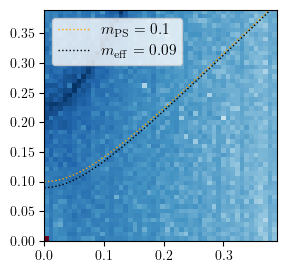

(1024, 1024)


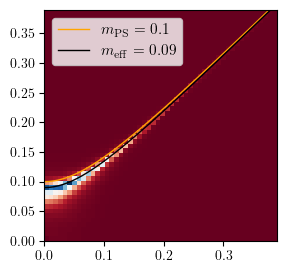

In [98]:
powspec_av = np.load('./data/average_PS_data.npy')
powspec_av = powspec_av[::2]
print(np.shape(powspec_av))

lat = np.arange(np.shape(powspec_av)[0])
ws = np.roll((lat - len(lat)//2)*dk, len(lat)//2)

lat = np.arange(np.shape(powspec_av)[1])
ks = np.roll((lat - len(lat)//2)*dk, len(lat)//2)

ws = ws[:50]
ks = ks[:50]
pspecs = powspec_av[:50,:50]

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ext = [ks[0], ks[-1], ks[0], ks[-1]]
plt.plot(ks, np.sqrt(ks**2. + m2(lamb)), ls=':', lw=1, color='orange', label=r'$m_{\rm PS} = 0.1$')
plt.plot(ks, np.sqrt(ks**2. + 0.09**2.), ls=':', lw=1, color='k', label=r'$m_{\rm eff} = 0.09$')
plt.imshow(np.log(pspecs), extent=ext, aspect='auto', origin='lower', interpolation='none', cmap='RdBu')
plt.legend(); plt.show()

powspec_av = np.load('./data/bubble_average_PS_data.npy')

print(np.shape(powspec_av))

lat = np.arange(np.shape(powspec_av)[0])
ws = np.roll((lat - len(lat)//2)*dk, len(lat)//2)

lat = np.arange(np.shape(powspec_av)[1])
ks = np.roll((lat - len(lat)//2)*dk, len(lat)//2)

ws = ws[:50]
ks = ks[:50]
pspecs = powspec_av[:50,:50]

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ext = [ks[0], ks[-1], ks[0], ks[-1]]
plt.plot(ks, np.sqrt(ks**2. + m2(lamb)), ls='-', lw=1, color='orange', label=r'$m_{\rm PS} = 0.1$')
plt.plot(ks, np.sqrt(ks**2. + 0.09**2.), ls='-', lw=1, color='k', label=r'$m_{\rm eff} = 0.09$')
plt.imshow(pspecs, extent=ext, aspect='auto', origin='lower', interpolation='none', cmap='RdBu')
plt.legend(); plt.show()

In [25]:
avPowSpec    = np.load('./data/average_PS_data_T'+str(temp)+'.npy')
avfieldvar   = np.load('./data/average_avfieldvar_data_T'+str(temp)+'.npy')
avmomvar     = np.load('./data/average_avmomvar_data_T'+str(temp)+'.npy')


FileNotFoundError: [Errno 2] No such file or directory: './data/average_PS_data_T0.09.npy'

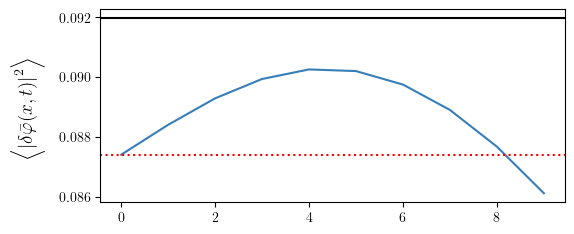

In [12]:
free_eigenbasis    = lambda la, ph0: np.asarray([norm(ph0)/(w2(la)[k]**0.25) if kk!=0. else 0. for k,kk in enumerate(klist)])
thermal_eigenbasis = lambda la, ph0, te: free_eigenbasis(la, ph0) * np.sqrt(2./(np.exp(w2(la)**0.5/te)-1.))
pspec       = lambda la, ph0, te: np.abs(thermal_eigenbasis(la, ph0, te))**2.
fluct_var = lambda la, ph0, te: np.sum(thermal_pspec(la, ph0, te))

fig, ax = plt.subplots(1,1, figsize = (6.,2.5))
plt.plot(np.arange(len(avfieldvar[:10])), avfieldvar[:10])
plt.axhline(fluct_var(lamb,phi0,temp), color='k')
plt.axhline(avfieldvar[0], color='r', ls=':')
#plt.axhline(np.mean(avfieldvar), color='g', ls=':')
plt.ylabel(r'$\left\langle \left|\delta \bar{\varphi} (x,t) \right| ^2 \right\rangle$')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (5120,) and (4847,)

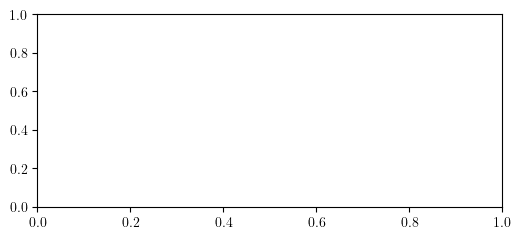

In [13]:
free_eigenbasis    = lambda la, ph0: np.asarray([norm(ph0)*(w2(la)[k]**0.25) if kk!=0. else 0. for k,kk in enumerate(klist)])
thermal_eigenbasis = lambda la, ph0, te: free_eigenbasis(la, ph0) * np.sqrt(2./(np.exp(w2(la)**0.5/te)-1.))
pspec     = lambda la, ph0, te: np.abs(thermal_eigenbasis(la, ph0, te))**2.
fluct_var = lambda la, ph0, te: np.sum(thermal_pspec(la, ph0, te))

fig, ax = plt.subplots(1,1, figsize = (6.,2.5))
plt.plot(np.arange(nLat*5), avmomvar)
plt.axhline(fluct_var(lamb,phi0,temp), color='k')
plt.axhline(avmomvar[0], color='r', ls=':')
plt.axhline(np.mean(avmomvar), color='g', ls=':')
plt.ylabel(r'$\left\langle \left|\delta \bar{\Pi} (x,t) \right| ^2 \right\rangle$')
plt.show()

1024 1024


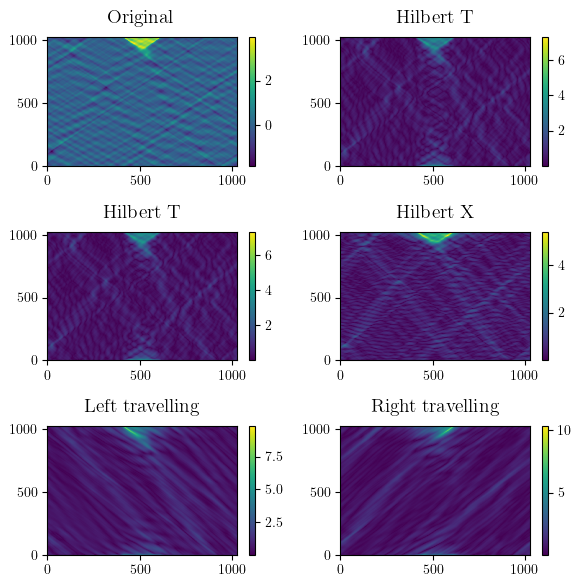

In [99]:
# One example
sim = simLists[0]
bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
nT, nN = np.shape(bubble); print(nT, nN)

aHT = get_HT(bubble)
tHD, xHD, lHD, rHD = get_4T(bubble)

fig, ax = plt.subplots(3, 2, figsize=(6,6))
im0 = ax[0,0].imshow(bubble, aspect='auto', interpolation='none', origin='lower')
im1 = ax[0,1].imshow(aHT, aspect='auto', interpolation='none', origin='lower')
im2 = ax[1,0].imshow(tHD, aspect='auto', interpolation='none', origin='lower')
im3 = ax[1,1].imshow(xHD, aspect='auto', interpolation='none', origin='lower')
im4 = ax[2,0].imshow(lHD, aspect='auto', interpolation='none', origin='lower')
im5 = ax[2,1].imshow(rHD, aspect='auto', interpolation='none', origin='lower')

im = [im0,im1,im2,im3,im4,im5]
titls = [r'$\rm Original$', r'$\rm Hilbert \; T$', r'$\rm Hilbert \; T$', 
         r'$\rm Hilbert \; X$', r'$\rm Left \; travelling$', r'$\rm Right \; travelling$']
for ii in range(len(im)):
    ax[np.divmod(ii,2)].set_title(titls[ii])
    plt.colorbar(im[ii], ax=ax[np.divmod(ii,2)])
plt.tight_layout()
plt.show()

In [100]:
aHD = get_HT(bubble)

bubble = bubble[500:-50,:]
aHD = aHD[500:-50,:]
nT, nN = np.shape(bubble)



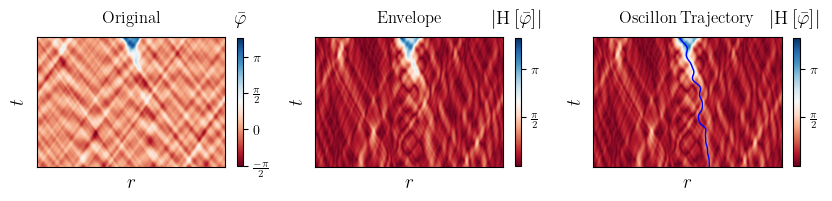

In [103]:
amp = 3
t = aHD**amp / np.sum(aHD**amp, axis=1)[:,None] 
SB = t*np.arange(nN)[None,:]
xt = np.sum(SB, axis=1)
ext = [0, nN, 0, nT]
fig, ax = plt.subplots(1, 3, figsize=(8.5,4))
im1 = ax[0].imshow(bubble, aspect='auto', extent=ext, interpolation=None, origin='lower', cmap='RdBu') #original
im2 = ax[1].imshow(aHD, aspect='auto', extent=ext, interpolation=None, origin='lower', cmap='RdBu') #hilbert transform amplitude
im3 = ax[2].imshow(aHD, aspect='auto', extent=ext, interpolation=None, origin='lower', cmap='RdBu') #power spectrum method

l1 = get_osc_trajectory(aHD, extent=deltae)
l2 = gaussian_filter1d(l1, sigma=10, mode='nearest')
ylist = np.arange(nT)
ax[2].plot(l2, ylist, color='b', linewidth=1)

titls = [r'$\rm Original$', r'$\rm Envelope$', r'$\rm Oscillon \; Trajectory$']
for ai, aa in enumerate(ax):
    aa.set_title(titls[ai], fontsize=12)
    cbar = plt.colorbar([im1, im2, im3][ai], ax=aa, shrink=0.35, \
                                ticks=mticker.MultipleLocator(np.pi/2), \
                                format=mticker.FuncFormatter(multiple_formatter()))
    cbar.ax.set_title([r'$\bar{\varphi}$', r'$\left|{\rm H} \left[\bar{\varphi}\right]\right|$', \
                       r'$\left|{\rm H} \left[\bar{\varphi}\right]\right|$'][ai])
    aa.tick_params(direction='in', which='both', top=True, right=True)
    aa.grid(ls=':', color='darkgray', alpha=0.5)
    aa.set_ylabel(r'$t$', labelpad = 1)
    aa.set_xlabel(r'$r$', labelpad = 1)
    aa.set_aspect(1.5)
    aa.yaxis.set_ticks_position('both')
    aa.xaxis.set_ticks_position('both')
    aa.xaxis.set_label_coords(0.5, -0.05)
    aa.yaxis.set_label_coords(-0.05, 0.5)
    aa.xaxis.label.set_color('k')        #setting up X-axis label color to yellow
    aa.yaxis.label.set_color('k')          #setting up Y-axis label color to blue
    aa.tick_params(axis='x', colors='k')    #setting up X-axis tick color to red
    aa.tick_params(axis='y', colors='k')  #setting up Y-axis tick color to black
    aa.spines['left'].set_color('k')        # setting up Y-axis tick color to red
    aa.spines['right'].set_color('k')        # setting up Y-axis tick color to red
    aa.spines['top'].set_color('k')         #setting up above X-axis tick color to red
    aa.spines['bottom'].set_color('k')         #setting up above X-axis tick color to red
    aa.get_xaxis().set_ticks([])
    aa.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig('./plots/oscillon_extraction.pdf')
plt.show()

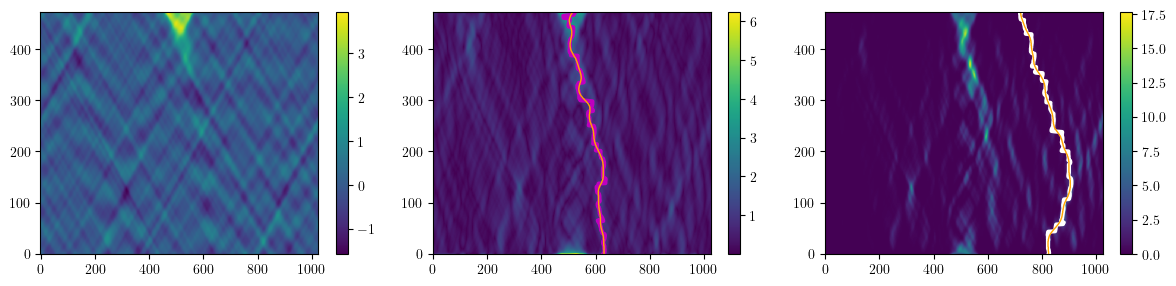

In [104]:
nT, nN = np.shape(bubble)
aHD = get_HT(bubble)

amp = 3
t = aHD**amp / np.sum(aHD**amp, axis=1)[:,None] 
SB = t*np.arange(nN)[None,:]
xt = np.sum(SB, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(12,3))
im1 = ax[0].imshow(bubble, aspect='auto', interpolation='none', origin='lower') #original
im2 = ax[1].imshow(aHD,     aspect='auto', interpolation='none', origin='lower') #hilbert transform amplitude
im3 = ax[2].imshow(SB,      aspect='auto', interpolation='none', origin='lower') #power spectrum method

l1 = get_osc_trajectory(aHD, extent=deltae)
l2 = gaussian_filter1d(l1, sigma=10, mode='nearest')

l3 = get_osc_trajectory(SB, extent=deltae)
l4 = gaussian_filter1d(l3, sigma=10, mode='nearest')

ylist = np.arange(nT)
ax[1].plot(l1, ylist, color='m', linewidth=3)
ax[1].plot(l2, ylist, color='orange', linewidth=1)

ax[2].plot(l3, ylist, color='white', linewidth=3)
ax[2].plot(l4, ylist, color='orange', linewidth=1)

plt.colorbar(im1, ax = ax[0])
plt.colorbar(im2, ax = ax[1])
plt.colorbar(im3, ax = ax[2])
plt.tight_layout()
plt.show()

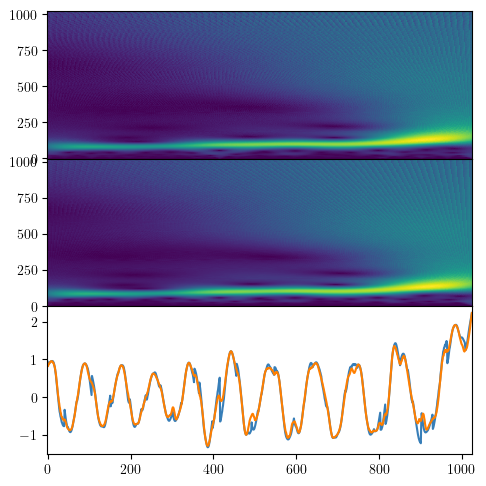

In [28]:
# wavelet transform on oscillon maplitude
C,B    = 1,1 # center, bandwidth # C = freq to investigate, B = bandwidth
wavelt = "cmor%f_%f"%(C,B)
dt     = 1
scales = np.arange(1, nT+1)

# construct field value of oscillon over trajectory above
oscillonAmp = bubble[np.arange(nT), l1] 
CC, f = pywt.cwt(oscillonAmp, scales, wavelt, sampling_period=dt)

smoscillonAmp = bubble[np.arange(nT), l2]
BB, f = pywt.cwt(smoscillonAmp, scales, wavelt, sampling_period=dt)

fig, ax = plt.subplots(3, 1, figsize=(5, 5), gridspec_kw=dict(hspace=0), sharex=True)
ax[0].imshow(np.abs(CC), aspect='auto', interpolation='none', origin='lower')
ax[1].imshow(np.abs(BB), aspect='auto', interpolation='none', origin='lower')
ax[2].plot(oscillonAmp)
ax[2].plot(smoscillonAmp)
plt.tight_layout()
plt.show()

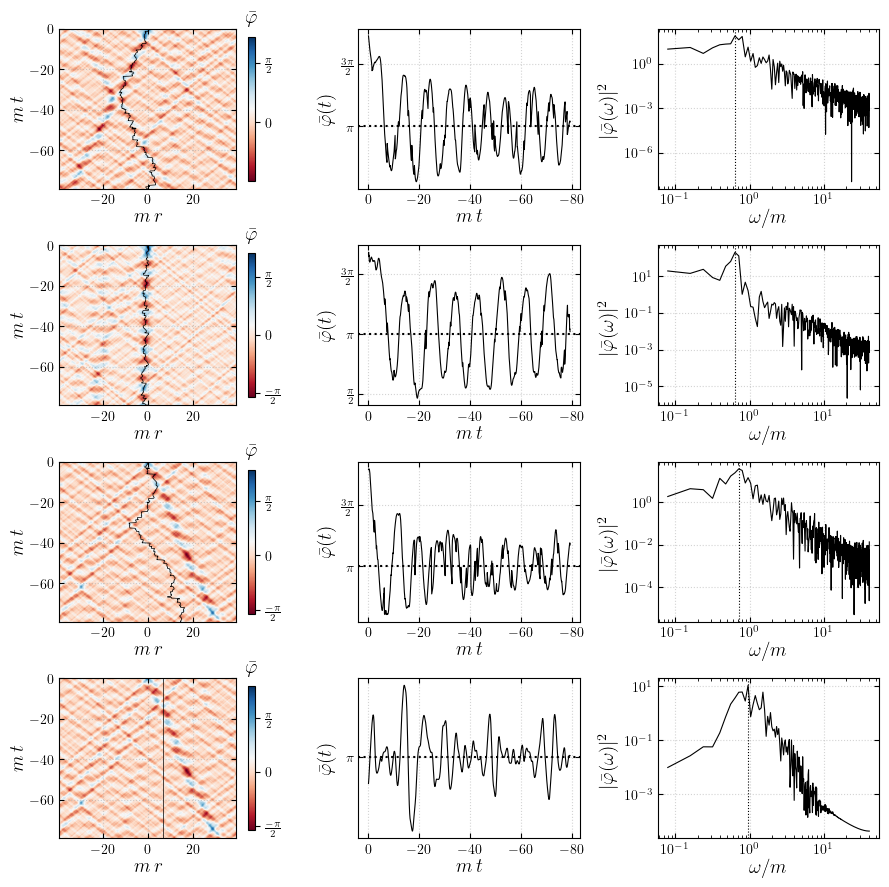

In [56]:
#oscillonWT = []
if not saveData:
    fig, ax = plt.subplots(4, 3, figsize = (9.,9.), gridspec_kw={'height_ratios':[1,1,1,1], 'width_ratios': [1,1,1]})
    ct = 0
    for si, sim in enumerate(simLists):
        if sim not in [17, 2277, 3370]: continue

        bubble, mn = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        try:
            nT, nN = np.shape(bubble)
            aHD = get_HT(bubble)
        except:
            continue

        maxln1 = get_osc_trajectory(aHD, extent=deltae)
        avOscillon = bubble[np.arange(nT), maxln1][::-1]
        maxln1-= nN//2

        exts = np.array([-nN//2,nN//2,-nT,0]) * dx * np.sqrt(m2(lamb))
        im1 = ax[ct, 0].imshow(bubble, extent=exts, aspect='auto', interpolation='none', origin='lower', cmap='RdBu') #original

        ylist = np.linspace(-nT, 0, len(maxln1)) * dx * np.sqrt(m2(lamb))
        ax[ct, 0].plot(maxln1 * dx * np.sqrt(m2(lamb)), ylist, ls='-', color='k', linewidth=0.5)

        ax[ct, 0].set_xlabel(r'$m \, r$', labelpad=8)
        ax[ct, 0].set_ylabel(r'$m \, t$', labelpad=8)
        ax[ct, 0].tick_params(direction='in', which='both', top=True, right=True)
        ax[ct, 0].grid(ls=':', color='darkgray', alpha=0.5)

        cbar = fig.colorbar(im1, ax=ax[ct, 0], ticks=mticker.MultipleLocator(np.pi/2), \
                            format=mticker.FuncFormatter(multiple_formatter()), shrink=0.9)
        cbar.ax.set_title(r'$\bar{\varphi}$')

        ax[ct, 1].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        ax[ct, 1].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        ax[ct, 1].axhline(phieq, ls=':', color='k')

        ax[ct, 1].plot(ylist, avOscillon[::-1] + mn, color='k', ls='-', lw=0.8)
        ax[ct, 1].invert_xaxis()
        ax[ct, 1].set_xlabel(r'$m \, t$', labelpad=8)
        ax[ct, 1].set_ylabel(r'$\bar{\varphi}(t)$', labelpad=8)

        y_fft = np.fft.fft(avOscillon, norm='ortho')
        freqs = np.fft.fftfreq(nT, d=1) * nT
        psyfd = (np.conj(y_fft)*y_fft).real
        ind   = np.argmax(psyfd[freqs>0])

        ax[ct, 2].axvline(freqs[freqs>0][ind] * dk2ploit, ls=':', color='k', lw=0.8)
        ax[ct, 2].ticklabel_format(axis='both', style='scientific', scilimits=[0.,0.])
        ax[ct, 2].loglog(freqs[freqs>0] * dk2ploit, psyfd[freqs>0], color='k', linewidth=0.8)
        ax[ct, 2].set_xlabel(r'$\omega / m$', labelpad=8)
        ax[ct, 2].set_ylabel(r'$|\bar{\varphi}(\omega)|^2$', labelpad=8)

        ct+=1
        
        if sim == 3370:

            bubble, mn = get_bubble(exp_params, sim, crit_thresh, crit_rad)
            try:
                nT, nN = np.shape(bubble)
                aHD = get_HT(bubble)
            except:
                continue

            maxln1 = np.random.randint(0,nN-1)
            avOscillon = bubble[np.arange(nT), maxln1][::-1]
            maxln1-= nN//2

            im1 = ax[ct, 0].imshow(bubble, extent=exts, aspect='auto', interpolation='none', origin='lower', cmap='RdBu') #original

            ylist = np.linspace(-nT, 0, len(avOscillon)) * dx * np.sqrt(m2(lamb))
            ax[ct, 0].plot(maxln1 * dx * np.sqrt(m2(lamb)) * np.ones(len(avOscillon)), ylist, ls='-', color='k', linewidth=0.5)

            ax[ct, 0].set_xlabel(r'$m \, r$', labelpad=8)
            ax[ct, 0].set_ylabel(r'$m \, t$', labelpad=8)
            ax[ct, 0].tick_params(direction='in', which='both', top=True, right=True)
            ax[ct, 0].grid(ls=':', color='darkgray', alpha=0.5)

            cbar = fig.colorbar(im1, ax=ax[ct, 0], ticks=mticker.MultipleLocator(np.pi/2), \
                                format=mticker.FuncFormatter(multiple_formatter()), shrink=0.9)
            cbar.ax.set_title(r'$\bar{\varphi}$')

            ax[ct, 1].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
            ax[ct, 1].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
            ax[ct, 1].axhline(phieq, ls=':', color='k')

            ax[ct, 1].plot(ylist, avOscillon[::-1] + mn, color='k', ls='-', lw=0.8)
            ax[ct, 1].invert_xaxis()
            ax[ct, 1].set_xlabel(r'$m \, t$', labelpad=8)
            ax[ct, 1].set_ylabel(r'$\bar{\varphi}(t)$', labelpad=8)

            y_fft = np.fft.fft(avOscillon, norm='ortho')
            freqs = np.fft.fftfreq(nT, d=1) * nT
            psyfd = (np.conj(y_fft)*y_fft).real
            ind   = np.argmax(psyfd[freqs>0])

            ax[ct, 2].axvline(freqs[freqs>0][ind] * dk2ploit, ls=':', color='k', lw=0.8)
            ax[ct, 2].ticklabel_format(axis='both', style='scientific', scilimits=[0.,0.])
            ax[ct, 2].loglog(freqs[freqs>0] * dk2ploit, psyfd[freqs>0], color='k', linewidth=0.8)
            ax[ct, 2].set_xlabel(r'$\omega / m$', labelpad=8)
            ax[ct, 2].set_ylabel(r'$|\bar{\varphi}(\omega)|^2$', labelpad=8)
    for ai, aa in enumerate(ax.flatten()):
        aa.grid(True, ls=':', color='darkgray', alpha=0.5)
        aa.tick_params(direction='in', which='both', top=True, right=True)
        aa.xaxis.set_label_coords(0.5, -0.12)
        if ai not in [1,4,7,10]:
            aa.yaxis.set_label_coords(-0.18, 0.5)
        else:
            aa.yaxis.set_label_coords(-0.1, 0.5)

    plt.tight_layout()
    plt.subplots_adjust(wspace=(0.35), hspace=0.35)
    plt.savefig('./plots/fft_oscillons.pdf')
    plt.show()

SIMULATION 17 (1024,)


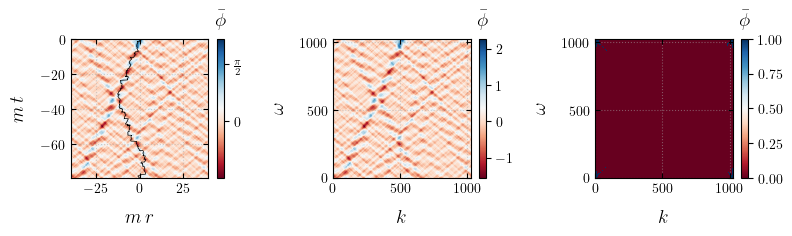

SIMULATION 379 (1024,)


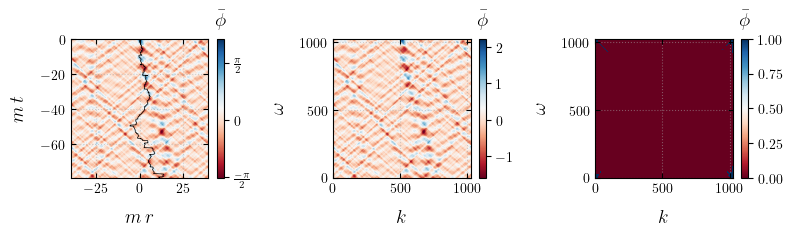

SIMULATION 656 (1024,)


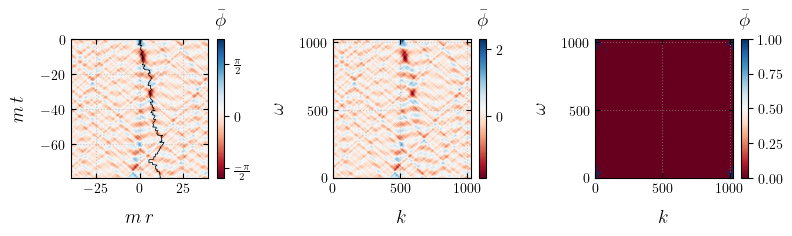

SIMULATION 1036 (1024,)


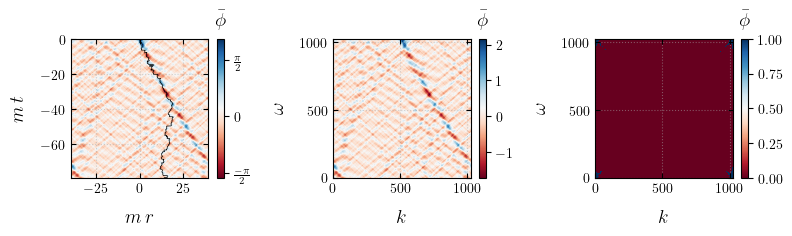

SIMULATION 1524 (1024,)


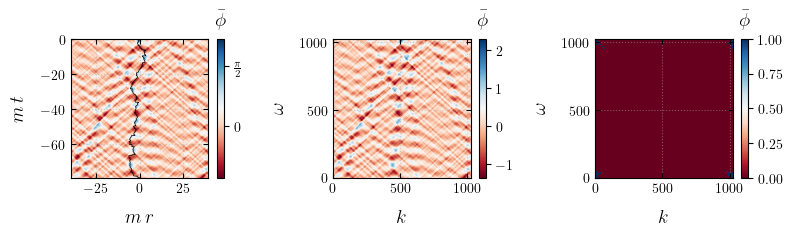

SIMULATION 1906 (1024,)


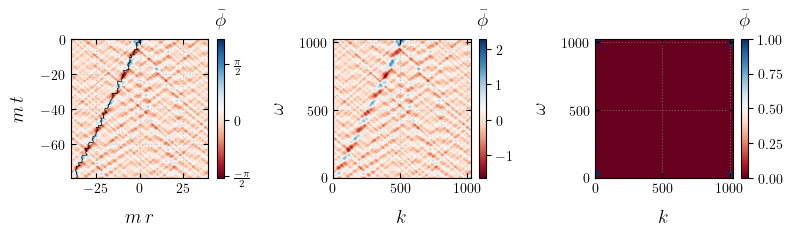

SIMULATION 2277 (1024,)


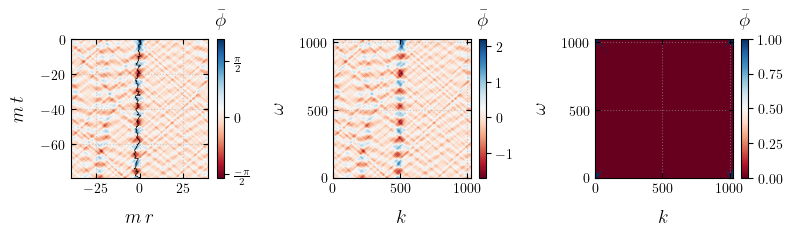

SIMULATION 2583 (1024,)


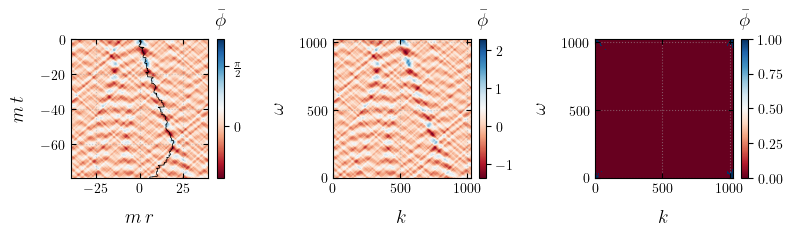

SIMULATION 2963 (1024,)


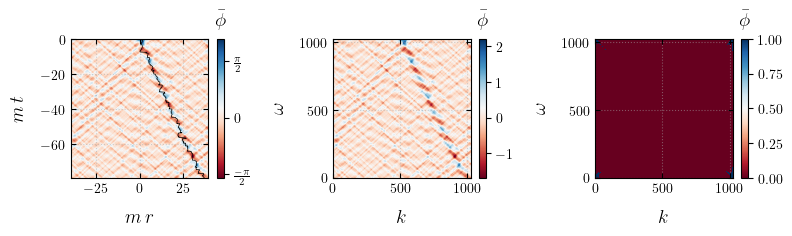

SIMULATION 3370 (1024,)


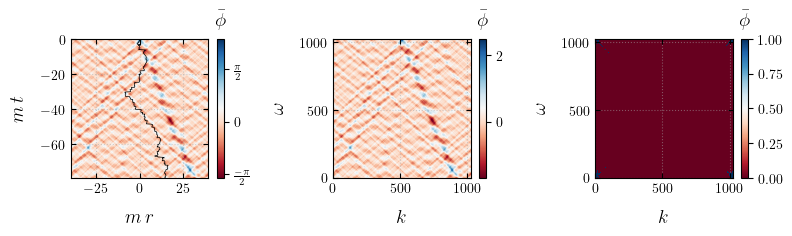

SIMULATION 3697 (1024,)


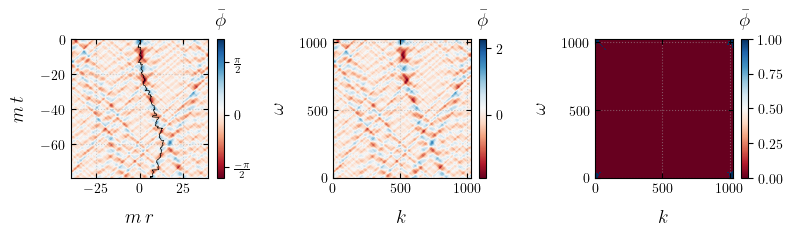

In [14]:
#oscillonWT = []
if not saveData:
    for si, sim in enumerate(simLists):
        if si%50!=1: continue

        bubble, mn = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        try:
            nT, nN = np.shape(bubble)
            aHD = get_HT(bubble)
        except:
            continue

        maxln1 = get_osc_trajectory(aHD, extent=deltae)
        avOscillon = bubble[np.arange(nT), maxln1][::-1]
        maxln1-= nN//2

    #    # wavelet transform on oscillon maplitude
    #    C,B     = 1,1 # center, bandwidth # C = freq to investigate, B = bandwidth
    #    wavelet = "cmor%f_%f"%(C,B)
    #    dt      = 1
    #    scales  = np.arange(1,nT)
    #    CC, f   = pywt.cwt(avOscillon, scales, wavelet, sampling_period=dt)
    #    oscillonWT.append(CC)

        print('SIMULATION', sim, np.shape(avOscillon))
        fig, ax = plt.subplots(1, 3, figsize=(8, 2.5))

        exts = np.array([-nN//2,nN//2,-nT,0]) * dx * np.sqrt(m2(lamb))
        im1 = ax[0].imshow(bubble, extent=exts, aspect='auto', interpolation='none', origin='lower', cmap='RdBu') #original

        ylist = np.linspace(-nT, 0, len(maxln1)) * dx * np.sqrt(m2(lamb))
        ax[0].plot(maxln1 * dx * np.sqrt(m2(lamb)), ylist, ls='-', color='k', linewidth=0.5)

        ax[0].set(xlabel=r'$m \, r$')
        ax[0].set(ylabel=r'$m \, t$')
        ax[0].tick_params(direction='in', which='both', top=True, right=True)
        ax[0].grid(ls=':', color='darkgray', alpha=0.5)

        cbar = fig.colorbar(im1, ax=ax[0], ticks=mticker.MultipleLocator(np.pi/2), \
                            format=mticker.FuncFormatter(multiple_formatter()))
        cbar.ax.set_title(r'$\bar{\phi}$')

        im2 = ax[1].imshow(bubble, aspect='auto', interpolation='none', origin='lower', cmap='RdBu')
        ax[1].set_xlabel(r'$k$')
        ax[1].set_ylabel(r'$\omega$')

        cbar = fig.colorbar(im2, ax=ax[1])
        cbar.ax.set_title(r'$\bar{\phi}$')

        im3 = ax[2].imshow((np.abs(np.fft.fft2(bubble))**2.)>1e5, aspect='auto', interpolation='none', origin='lower', cmap='RdBu')
        ax[2].set_xlabel(r'$k$')
        ax[2].set_ylabel(r'$\omega$')

        cbar = fig.colorbar(im3, ax=ax[2])
        cbar.ax.set_title(r'$\bar{\phi}$')

        for aa in ax:
            aa.grid(True, ls=':', color='darkgray', alpha=0.5)
            aa.tick_params(direction='in', which='both', top=True, right=True)

        plt.tight_layout()
        plt.savefig('./plots/fft_oscillon'+str(sim)+'.pdf', dpi=500)
        plt.show()

SIMULATION 7 (1024,)


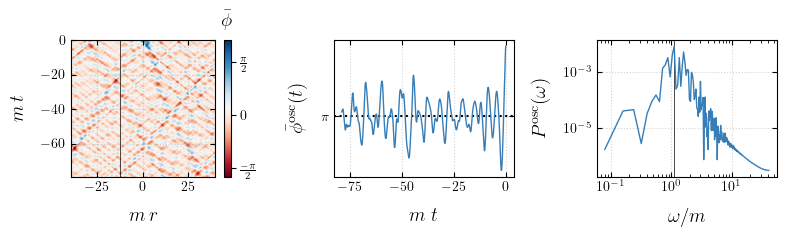

SIMULATION 651 (1024,)


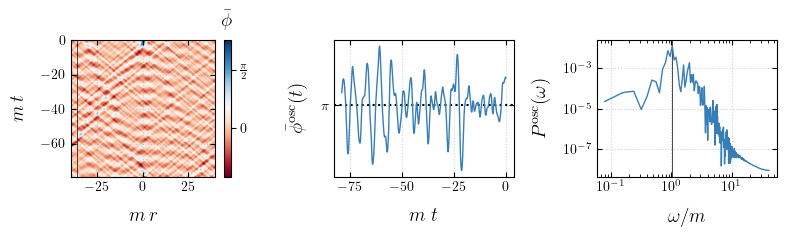

SIMULATION 1519 (1024,)


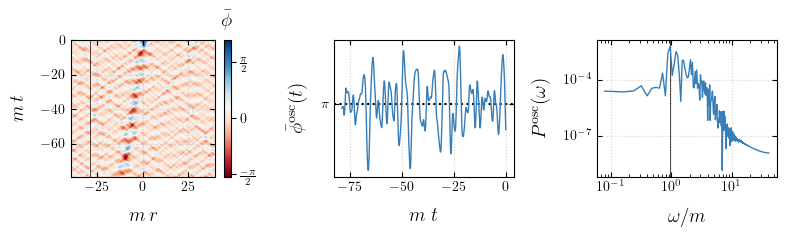

SIMULATION 2276 (1024,)


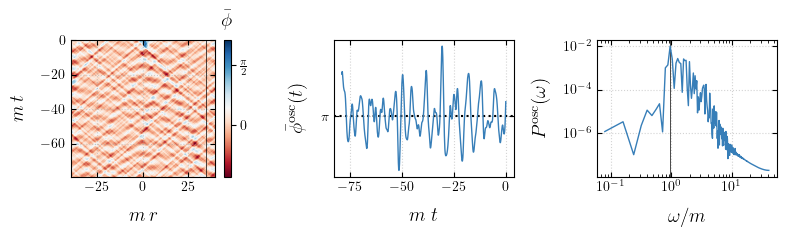

SIMULATION 2961 (1024,)


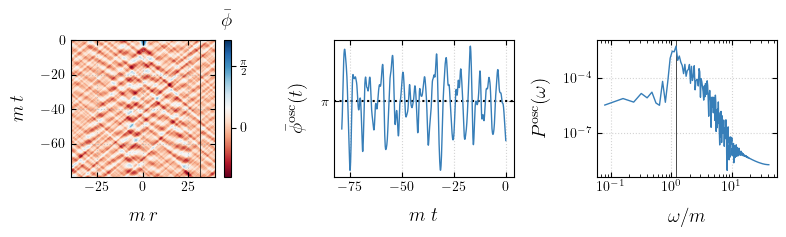

SIMULATION 3696 (1024,)


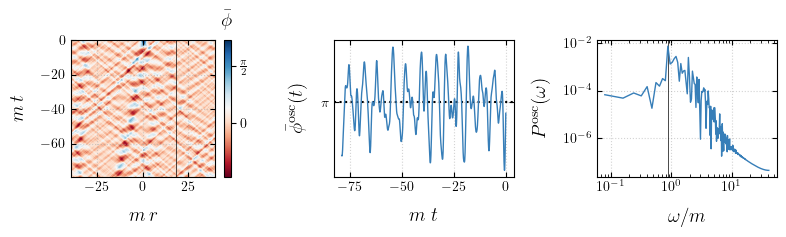

In [27]:
#oscillonWT = []
if not saveData:
    for si, sim in enumerate(simLists):
        if si%100!=0: continue

        bubble, mn = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        try:
            nT, nN = np.shape(bubble)
            aHD = get_HT(bubble)
        except:
            continue

        xrand = np.random.randint(0,nN-1)
        avOscillon = bubble[np.arange(nT), xrand][::-1]
        xrand-=nN//2

    #    # wavelet transform on oscillon maplitude
    #    C,B     = 1,1 # center, bandwidth # C = freq to investigate, B = bandwidth
    #    wavelet = "cmor%f_%f"%(C,B)
    #    dt      = 1
    #    scales  = np.arange(1,nT)
    #    CC, f   = pywt.cwt(avOscillon, scales, wavelet, sampling_period=dt)
    #    oscillonWT.append(CC)

        print('SIMULATION', sim, np.shape(avOscillon))
        fig, ax = plt.subplots(1, 3, figsize=(8, 2.5))

        exts = np.array([-nN//2,nN//2,-nT,0]) * dx * np.sqrt(m2(lamb))
        im1 = ax[0].imshow(bubble, extent=exts, aspect='auto', interpolation='none', origin='lower', cmap='RdBu') #original

        ylist = np.linspace(-nT, 0, len(avOscillon)) * dx * np.sqrt(m2(lamb))
        ax[0].plot(xrand * dx * np.sqrt(m2(lamb)) * np.ones(len(avOscillon)), ylist, ls='-', color='k', linewidth=0.5)

        ax[0].set(xlabel=r'$m \, r$')
        ax[0].set(ylabel=r'$m \, t$')
        ax[0].tick_params(direction='in', which='both', top=True, right=True)
        ax[0].grid(ls=':', color='darkgray', alpha=0.5)

        cbar = fig.colorbar(im1, ax=ax[0], ticks=mticker.MultipleLocator(np.pi/2), \
                            format=mticker.FuncFormatter(multiple_formatter()))
        cbar.ax.set_title(r'$\bar{\phi}$')

        ax[1].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        ax[1].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        ax[1].axhline(phieq, ls=':', color='k')

        ax[1].plot(ylist, avOscillon + mn, ls='-', lw=1)
        ax[1].set_xlabel(r'$m \; t$')
        ax[1].set_ylabel(r'$\bar{\phi}^{\rm osc}(t)$')

        y_fft = np.fft.fft(avOscillon, norm='forward')
        freqs = np.fft.fftfreq(nT, d=1) * nT
        psyfd = (np.conj(y_fft)*y_fft).real
        ind   = np.argmax(psyfd[freqs>0])

#        ax[2].loglog(freqs[ind] * dk2ploit, psyfd[ind], 'o')
        ax[2].axvline(freqs[freqs>0][ind] * dk2ploit, ls='-', color='k', lw=0.5)
        ax[2].loglog(freqs[freqs>0] * dk2ploit, psyfd[freqs>0], linewidth=1)
        ax[2].set_xlabel(r'$\omega / m$')
        ax[2].set_ylabel(r'$P^{\rm osc}(\omega)$')
#        ax[2].set_ylim((1e-7,2e-1))
#        ax[2].set_xlim((freqs[0], freqs[25]))

        for aa in ax:
            aa.grid(True, ls=':', color='darkgray', alpha=0.5)
            aa.tick_params(direction='in', which='both', top=True, right=True)

        plt.tight_layout()
        plt.show()

### FT of Oscillon Signal

In [13]:
if saveData:
    savefrqT, savefrqX, savePST, savePSX = [], [], [], []
    for si, sim in enumerate(simLists):
        bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        try:
            nT, nN = np.shape(bubble)
        except:
            continue

        bubbleT = np.fft.fft(bubble, axis=0)
        freqsT  = np.fft.fftfreq(nT, d=1) * nT # get frequencies; d = x space units
        freqsT  = np.outer(freqsT, np.ones(nN))
        PST     = (np.conj(bubbleT)*bubbleT).real

        bubbleX = np.fft.fft(bubble, axis=1)
        freqsX  = np.fft.fftfreq(nN, d=1) * nN
        freqsX  = np.outer(np.ones(nT), freqsX)
        PSX     = (np.conj(bubbleX)*bubbleX).real

        valMax  = 2e4
        coordsT = (PST>=valMax) # separate freqs where there is large field response
        coordsX = (PSX>=valMax)

        savefrqT.append(freqsT[coordsT])
        savefrqX.append(freqsX[coordsX])

        savePST.append(PST[coordsT])
        savePSX.append(PSX[coordsX])

    set_Tfreqs, set_Xfreqs, set_Ttotamps, set_Xtotamps = get_cummul_power(freqsT, freqsX, PST, PSX)
    del freqsT, freqsX, PST, PSX

    np.save('./data/oscillon_freqs.npy', np.array([set_Tfreqs, set_Xfreqs, set_Ttotamps, set_Xtotamps]))


In [ ]:
if saveData:
    # plot frequency vs response; plot mass from frequency and compare with free mass
    set_Tfreqs, set_Xfreqs, set_Ttotamps, set_Xtotamps = np.load('./data/oscillon_freqs.npy')
    masses = set_Tfreqs[:,None]**2. - set_Xfreqs[None,:]**2.
    masses = masses.flatten()
    masses = masses[masses>0.]

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax[0].plot(set_Tfreqs, set_Ttotamps)
    ax[0].set_xlabel(r'$\omega$')
    ax[1].plot(set_Xfreqs, set_Xtotamps)
    ax[1].set_xlabel(r'$k$')
    ah = ax[2].hist(masses, bins=10, density=True)
    ax[2].set_xlabel(r'$m$')

    #for aa in ax: aa.set_yscale('log')
    plt.tight_layout()
    plt.show()


In [30]:
def omega(ksq, a, m):
    return a*ksq + m**2

if False:
    fig, ax = plt.subplots(1, 2, figsize=(6, 2))
    for si, sim in enumerate(simLists):
        bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        nT, nN = np.shape(bubble)

        bubblePS = np.fft.fft2(bubble)[:nT//6,:nN//6]
        bubblePS = np.conj(bubblePS)*bubblePS

        maxVal = 5e6
        bubble_coords = np.argwhere(bubblePS>maxVal)

        kkk, ooo = bubble_coords[:,1]**2., bubble_coords[:,0]**2.
        popt2, pcov2 = sco.curve_fit(omega, kkk, ooo)

        if True:
            if si%10!=4: continue
            ax[0].imshow(bubblePS.real>maxVal, aspect='auto', interpolation='none', origin='lower')

            ax[1].plot(kkk, omega(kkk, *popt2), '-')#, label='fit: a=%5.3f, m=%5.3f' % tuple(popt2))
            ax[1].plot(kkk, ooo, 'go', ms=1)
    for aa in ax:
        aa.set_xlabel(r'$k^2$')
        aa.set_ylabel(r'$\omega_k^2$')
    plt.show()

### Average Oscillon Signal

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Mean of empty slice
/home/dpirvu/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


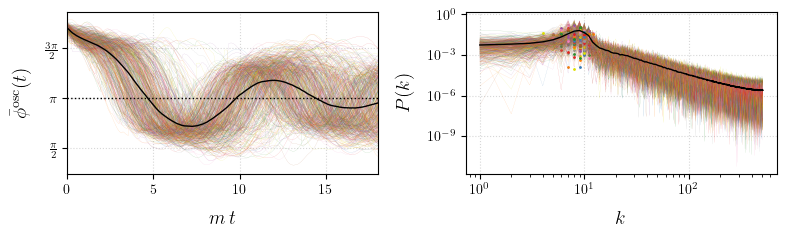

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (8, 2.5))

simLists, oscillonAmp, means = oscillonData[:,0], oscillonData[:,1], oscillonData[:,2]
for si, sim in enumerate(simLists):
    oscillon = oscillonAmp[si]
    mn = means[si]
    freqs, PS_oscillon, ind = oscillonFreqData[si]

    nT = len(oscillon)
    ax[0].plot(np.sqrt(m2(lamb))*dx*np.arange(nT), oscillon + mn, linewidth=0.05)

    ax[1].loglog(freqs[freqs>0][ind], PS_oscillon[ind], 'o', ms=1)
    ax[1].loglog(freqs[freqs>0], PS_oscillon[freqs>0], linewidth=0.05)

avOS, error1 = tolerant_mean(oscillonAmp)
ax[0].plot(np.sqrt(m2(lamb))*dx*np.arange(len(avOS)), avOS + np.mean(means), linewidth=1, color='k')
ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax[0].axhline(phieq, ls=':', color='k', linewidth=1)
ax[0].set_xlabel(r'$m \, t$')
ax[0].set_ylabel(r'$\bar{\phi}^{\rm osc}(t)$')
ax[0].set_xlim(0, 18)#np.sqrt(m2(lamb))*dx*len(avOS))

avSP, error1 = tolerant_mean(oscillonFreqData[:,1])
avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
ax[1].plot(avfq[avfq>0], avSP[avfq>0], linewidth=1, color='k')
ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel(r'$P(k)$')

for aa in ax:
    aa.grid(True, ls=':', alpha=0.5)
plt.tight_layout()
plt.savefig('./plots/av_oscillon_and_freq.pdf', dpi=500, rasterize=True)
plt.show()

(1024, 342)
(1024, 342)


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


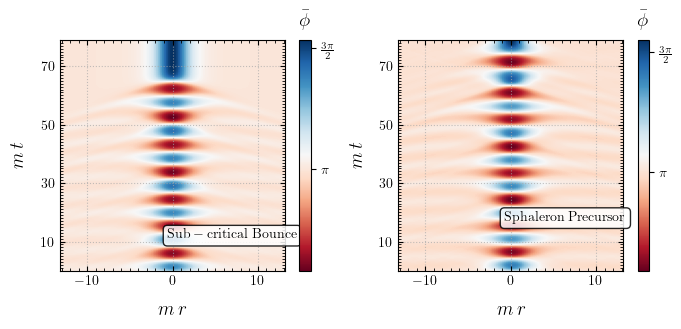

In [32]:
if True:
    titls = [r'$\rm Sub-critical \; Bounce$', r'$\rm Sphaleron \; Precursor$']

    home_dor = '/home/dpirvu/project/velocityCOM/paper_thermal/'
    sphaleron = home_dor+'instanton_x1024_phi01.3963_lambda1.5000_fields.dat'
    precursor = home_dor+'precursor_x1024_phi01.3963_lambda1.5000_T0.0900_sim0_fields.dat'

    instanton_sim = extract_data(nLat, sphaleron)
  #  instanton_sim = instanton_sim[0, :nLat*2//3, nLat//3:2*nLat//3+1][::-1]
    instanton_sim = instanton_sim[0, :nLat, nLat//3:2*nLat//3+1][::-1]
    nT, nN = np.shape(instanton_sim)
    print(np.shape(instanton_sim))

    precursor_sim = extract_data(nLat, precursor)
    precursor_sim = precursor_sim[0, :nT, nLat//3:2*nLat//3+1][::-1]
    print(np.shape(precursor_sim))

    exts = np.array([-nN//2,nN//2,0,nT])*dx*np.sqrt(m2(lamb))

    fig, ax = plt.subplots(1, 2, figsize = (8,3))
    im0 = ax[0].imshow(instanton_sim, aspect='auto', interpolation='none', extent=exts, origin='lower', cmap='RdBu')
    clb0 = plt.colorbar(im0, ax = ax[0], ticks = mticker.MultipleLocator(np.pi/2), format = mticker.FuncFormatter(multiple_formatter()))
    clb0.ax.set_title(r'$\bar{\phi}$')

    im1 = ax[1].imshow(precursor_sim, aspect='auto', interpolation='none', extent=exts, origin='lower', cmap='RdBu')
    clb1 = plt.colorbar(im1, ax = ax[1], ticks = mticker.MultipleLocator(np.pi/2), format = mticker.FuncFormatter(multiple_formatter()))
    clb1.ax.set_title(r'$\bar{\phi}$')

    for ai, aa in enumerate(ax):
        aa.text([7.,6.4][ai], [12.,18.][ai], titls[ai], ha='center', va='center', \
                bbox={'boxstyle':'round','facecolor':'white','alpha':0.85,'edgecolor':'k','pad':0.3}, fontsize=10)

        aa.grid(ls=':', color='darkgray', alpha=0.7)
        aa.xaxis.set_minor_locator(MultipleLocator(1))
        aa.yaxis.set_minor_locator(MultipleLocator(1))
        aa.set_xlabel(r'$m \, r$')
        aa.set_ylabel(r'$m \, t$')
        aa.yaxis.set_ticks_position('both')
        aa.xaxis.set_ticks_position('both')
        aa.tick_params(which='both', axis="y", direction="in")
        aa.tick_params(which='both', axis="x", direction="in")
        # a = aa.get_xticks().tolist()[1:-1:]
       # a = [round(al,2) for al in a]
       # aa.set_xticks(a)
        # aa.set_xticklabels(a)
        a = aa.get_yticks().tolist()[1:-1:2]
        a = [round(al,2) for al in a]
        aa.set_yticks(a)
        a = [r'${:.0f}$'.format(al) for al in a]
        aa.set_yticklabels(a)

    plt.savefig('./plots/standard_oscillons.pdf', dpi=500, rasterize=True)
    plt.show()


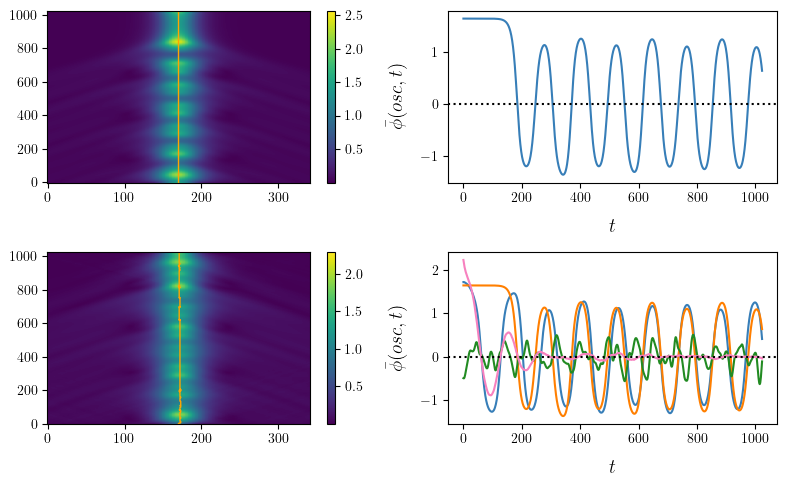

In [33]:
instanton_sim = instanton_sim - np.mean(instanton_sim)
nT, nN = np.shape(instanton_sim)
aHD_inst = get_HT(instanton_sim)

precursor_sim = precursor_sim - np.mean(precursor_sim)
aHD_prec = get_HT(precursor_sim)

fig, ax = plt.subplots(2, 2, figsize=(8,5))
im1 = ax[0,0].imshow(aHD_inst, aspect='auto', interpolation='none', origin='lower')
im2 = ax[1,0].imshow(aHD_prec, aspect='auto', interpolation='none', origin='lower')

l1 = get_osc_trajectory(aHD_inst, extent=deltae)
l2 = get_osc_trajectory(aHD_prec, extent=deltae)

ylist = np.arange(nT)
ax[0,0].plot(l1, ylist, color='orange', linewidth=1)
ax[1,0].plot(l2, ylist, color='orange', linewidth=1)

avOscillon_inst = instanton_sim[np.arange(nT), l1][::-1]
ax[0,1].plot(np.arange(nT), avOscillon_inst)
avOscillon_prec = precursor_sim[np.arange(nT), l2][::-1]
ax[1,1].plot(np.arange(nT), avOscillon_prec)
ax[1,1].plot(np.arange(nT), avOscillon_inst)
ax[1,1].plot(np.arange(len(avOscillon)), avOscillon)
ax[1,1].plot(np.arange(len(avOS)), avOS)

ax[0,1].set_xlabel(r'$t$')
ax[1,1].set_xlabel(r'$t$')
ax[0,1].set_ylabel(r'$\bar{\phi}(osc,t)$')
ax[1,1].set_ylabel(r'$\bar{\phi}(osc,t)$')
ax[0,1].axhline(0, ls=':', color='k')
ax[1,1].axhline(0, ls=':', color='k')

plt.colorbar(im1, ax = ax[0,0])
plt.colorbar(im2, ax = ax[1,0])
plt.tight_layout()
plt.show()

In [34]:
y_fft1  = np.fft.fft(avOscillon_inst, norm='forward')
freqs1 = np.fft.fftfreq(len(avOscillon_inst), d=1.) * len(avOscillon_inst)
psyfd1 = (np.conj(y_fft1)*y_fft1).real

y_fft2  = np.fft.fft(avOscillon_prec, norm='forward')
freqs2 = np.fft.fftfreq(len(avOscillon_prec), d=1.) * len(avOscillon_prec)
psyfd2 = (np.conj(y_fft2)*y_fft2).real

def get_nth_power_and_frequency(psyfd, freqs, n):
    elem = np.partition(psyfd[freqs>0].flatten(), -n)[-n]
    ind = np.argwhere(psyfd[freqs>0] == elem)
    freqmax = freqs[freqs>0][ind]
    return elem, freqmax



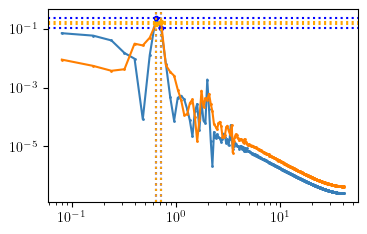

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))

plt.loglog(freqs1[freqs1>0]*dk2ploit, psyfd1[freqs1>0], ls='-', marker='o', ms=1, label=r'$\rm Sub-Critical$')

for nn in [1, 2]:
    elem, freqmax = get_nth_power_and_frequency(psyfd1, freqs1, nn)
    plt.plot(freqmax*dk2ploit, elem, color='b', marker='o', ms=3)
    plt.axvline(freqmax*dk2ploit, color='b', ls=':')
    plt.axhline(elem, color='b', ls=':')

plt.loglog(freqs2[freqs2>0]*dk2ploit, psyfd2[freqs2>0], ls='-', marker='o', ms=1, label=r'$\rm Precursor$')

for nn in [1, 2]:
    elem, freqmax = get_nth_power_and_frequency(psyfd2, freqs2, nn)
    plt.plot(freqmax*dk2ploit, elem, color='orange', marker='o', ms=3)
    plt.axvline(freqmax*dk2ploit, color='orange', ls=':')
    plt.axhline(elem, color='orange', ls=':')


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Mean of empty slice


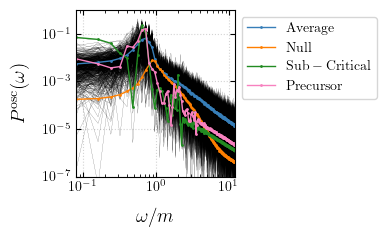

In [36]:
clss = allcolors[:4]

fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
simLists, oscillonAmp, means = oscillonData[:,0], oscillonData[:,1], oscillonData[:,2]
for si, sim in enumerate(simLists):
    oscillon, mn = oscillonAmp[si], means[si]
    freqs, PS_oscillon, ind = oscillonFreqData[si]
    plt.loglog(freqs[freqs>0]*dk2ploit, PS_oscillon[freqs>0], linewidth=0.1, color='k')

avSP, error1 = tolerant_mean(oscillonFreqData[:,1])
avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
plt.plot(avfq[avfq>0]*dk2ploit, avSP[avfq>0], color=clss[0], ls='-', marker='o', ms=1, lw=1, label=r'$\rm Average$')


avSP, error1 = tolerant_mean(NULLoscillonFreqData[:,1])
avfq, error1 = tolerant_mean(NULLoscillonFreqData[:,0])
plt.plot(avfq[avfq>0]*dk2ploit, avSP[avfq>0], color=clss[1], ls='-', marker='o', ms=1, lw=1, label=r'$\rm Null$')


plt.loglog(freqs1[freqs1>0]*dk2ploit, psyfd1[freqs1>0], color=clss[2], ls='-', marker='o', ms=1, lw=1, label=r'$\rm Sub-Critical$')
plt.loglog(freqs2[freqs2>0]*dk2ploit, psyfd2[freqs2>0], color=clss[3], ls='-', marker='o', ms=1, lw=1, label=r'$\rm Precursor$')

leg = ax.legend(ncol=1, loc='best', fontsize=10, bbox_to_anchor=(1, 1))

plt.ylim(1e-7,1e0)
plt.xlim((freqs2[1]*dk2ploit, freqs2[150]*dk2ploit))

plt.xlabel(r'$\omega / m$')
plt.ylabel(r'$P^{\rm osc}(\omega)$')
plt.grid(True, ls=':', color='darkgray', alpha=0.5)
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.tight_layout()
plt.savefig('./plots/all_freqs.pdf', dpi=500)
plt.show()

In [37]:
import seaborn as sns

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Mean of empty slice
/home/dpirvu/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[]

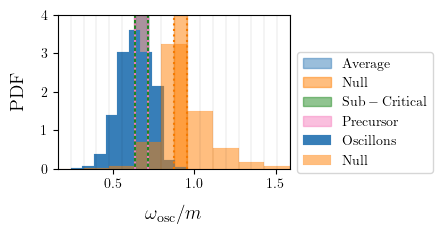

In [38]:
clss = allcolors[:4]

fig, ax = plt.subplots(1, 1, figsize=(3, 2.))

avSP, error1 = tolerant_mean(oscillonFreqData[:,1])
avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
freqtrain = np.zeros((2))
for ni, nn in enumerate([1, 2]):
    freqtrain[ni] = get_nth_power_and_frequency(avSP, avfq, nn)[1]
plt.axvline(dk2ploit*freqtrain[0], color=clss[0])
plt.axvline(dk2ploit*freqtrain[1], color=clss[0])
plt.fill_betweenx(np.linspace(0,4,10), dk2ploit*freqtrain[0], dk2ploit*freqtrain[1], color=clss[0], alpha=0.5, label=r'$\rm Average$')

avSP, error1 = tolerant_mean(NULLoscillonFreqData[:,1])
avfq, error1 = tolerant_mean(NULLoscillonFreqData[:,0])
freqtrain = np.zeros((2))
for ni, nn in enumerate([1, 2]):
    freqtrain[ni] = get_nth_power_and_frequency(avSP, avfq, nn)[1]
plt.axvline(dk2ploit*freqtrain[0], color=clss[1], ls=':')
plt.axvline(dk2ploit*freqtrain[1], color=clss[1], ls=':')
plt.fill_betweenx(np.linspace(0,4,10), dk2ploit*freqtrain[0], dk2ploit*freqtrain[1], color=clss[1], alpha=0.5, label=r'$\rm Null$')

freqtrain = np.zeros((2))
for ni, nn in enumerate([1, 2]):
    freqtrain[ni] = get_nth_power_and_frequency(psyfd1, freqs1, nn)[1]
plt.axvline(dk2ploit*freqtrain[0], color=clss[2])
plt.axvline(dk2ploit*freqtrain[1], color=clss[2])
plt.fill_betweenx(np.linspace(0,4,10), dk2ploit*freqtrain[0], dk2ploit*freqtrain[1], color=clss[2], alpha=0.5, label=r'$\rm Sub-Critical$')

freqtrain = np.zeros((2))
for ni, nn in enumerate([1, 2]):
    freqtrain[ni] = get_nth_power_and_frequency(psyfd2, freqs2, nn)[1]
plt.axvline(dk2ploit*freqtrain[0], color=clss[3], ls=':')
plt.axvline(dk2ploit*freqtrain[1], color=clss[3], ls=':')
plt.fill_betweenx(np.linspace(0,4,10), dk2ploit*freqtrain[0], dk2ploit*freqtrain[1], color=clss[3], alpha=0.5, label=r'$\rm Precursor$')


all_freqs, all_PS_oscillon, all_ind = oscillonFreqData[:,0], oscillonFreqData[:,1], oscillonFreqData[:,2]

freqs_vec = np.zeros(len(all_freqs))
for ii, ind in enumerate(all_ind):
    freqs_vec[ii] = all_freqs[ii][ind]

ah = plt.hist(dk2ploit*np.array(freqs_vec), color=clss[0], bins=10, 
              density=True, edgecolor = clss[0], linewidth=0.1, label=r'$\rm Oscillons$')

all_freqs, all_PS_oscillon, all_ind = NULLoscillonFreqData[:,0], NULLoscillonFreqData[:,1], NULLoscillonFreqData[:,2]

freqs_vec = np.zeros(len(all_freqs))
for ii, ind in enumerate(all_ind):
    freqs_vec[ii] = all_freqs[ii][ind]

ah = plt.hist(dk2ploit*np.array(freqs_vec), color=clss[1], bins=10, alpha=0.5, 
              density=True, edgecolor = clss[1], linewidth=0.1, label=r'$\rm Null$')

avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
[plt.axvline(dk2ploit*ii, color='k', ls='-', alpha=0.6, linewidth=0.1) for ii in avfq]
ax.set_xlim((avfq[2]*dk2ploit, avfq[20]*dk2ploit))
ax.set_ylim((0,4))

ax.set_ylabel(r'$\rm PDF$')
ax.set_xlabel(r'$\omega_{\rm osc} / m$')
leg = ax.legend(ncol=1, loc='best', fontsize=10, bbox_to_anchor=(1, 0.8))

plt.savefig('./plots/characteristic_osc_frequency.pdf', dpi=500)
plt.plot()


In [39]:
plt.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth
plt.rcParams['hatch.linewidth'] = 1.0  # previous svg hatch linewidth

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Mean of empty slice


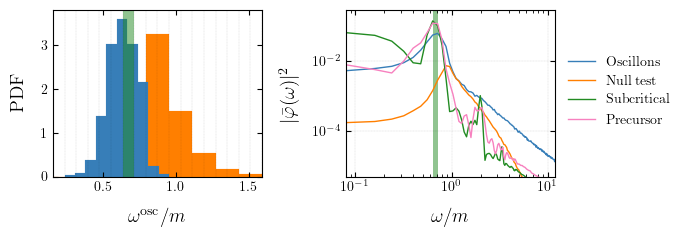

In [60]:
clss = allcolors[:4]

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))

avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
[ax[0].axvline(dk2ploit*ii, ls=':', color='k', alpha=0.5, lw=0.2) for ii in avfq]

#ax[0].axvline(1, ls='-', color='k', alpha=0.5, lw=0.5)
#ax[1].axvline(1, ls='-', color='k', alpha=0.5, lw=0.5)

all_freqs, all_PS_oscillon, all_ind = NULLoscillonFreqData[:,0], NULLoscillonFreqData[:,1], NULLoscillonFreqData[:,2]

freqs_vec = np.zeros(len(all_freqs))
for ii, ind in enumerate(all_ind):
    freqs_vec[ii] = all_freqs[ii][ind]

ah = ax[0].hist(dk2ploit*np.array(freqs_vec), color=clss[1], bins=10, alpha=1, ec=clss[1],
              density=True, edgecolor = clss[1], linewidth=0.1, label=r'$\rm Null$')



all_freqs, all_PS_oscillon, all_ind = oscillonFreqData[:,0], oscillonFreqData[:,1], oscillonFreqData[:,2]

freqs_vec = np.zeros(len(all_freqs))
for ii, ind in enumerate(all_ind):
    freqs_vec[ii] = all_freqs[ii][ind]

ah = ax[0].hist(dk2ploit*np.array(freqs_vec), color=clss[0], bins=10, alpha=1, ec=clss[0],
              density=True, edgecolor = clss[0], linewidth=0.1, label=r'$\rm Oscillons$')



freqtrain = np.zeros((2))
for ni, nn in enumerate([1, 2]):
    freqtrain[ni] = get_nth_power_and_frequency(psyfd1, freqs1, nn)[1]
#ax[0].axvline(dk2ploit*freqtrain[0], color=clss[2], ls='-', alpha=0.75)
#ax[0].axvline(dk2ploit*freqtrain[1], color=clss[2], ls='-', alpha=0.75)
ax[0].fill_betweenx(np.linspace(0,4,10), dk2ploit*freqtrain[0], dk2ploit*freqtrain[1], 
                    facecolor=clss[2], alpha=0.5, label=r'$\rm Subcritical$')
#ax[0].fill_betweenx(np.linspace(0,4,10), dk2ploit*freqtrain[0], dk2ploit*freqtrain[1], linewidth=0.0, \
#                    facecolor="none", hatch="+++", edgecolor=clss[2], alpha=0.75, label=r'$\rm Sub-Critical$')

ax[1].fill_betweenx(np.linspace(0,4,10), dk2ploit*freqtrain[0], dk2ploit*freqtrain[1], 
                    facecolor=clss[2], alpha=0.5)

freqtrain = np.zeros((2))
for ni, nn in enumerate([1, 2]):
    freqtrain[ni] = get_nth_power_and_frequency(psyfd2, freqs2, nn)[1]
#ax[0].axvline(dk2ploit*freqtrain[0], color=clss[3], ls=':', alpha=0.75)
#ax[0].axvline(dk2ploit*freqtrain[1], color=clss[3], ls=':', alpha=0.75)
#ax[0].fill_betweenx(np.linspace(0,4,10), dk2ploit*freqtrain[0], dk2ploit*freqtrain[1], linewidth=0.0, \
#                    facecolor="none", hatch="xxx", edgecolor=clss[3], alpha=0.75, label=r'$\rm Precursor$')



ax[0].set_xlim((avfq[2]*dk2ploit, avfq[20]*dk2ploit))
ax[0].set_ylim((0,3.8))
ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].set_ylabel(r'$\rm PDF$')
ax[0].set_xlabel(r'$\omega^{\rm osc} / m$')
#leg = ax[0].legend(ncol=1, loc='best', fontsize=10)

#avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
#[ax[1].axvline(dk2ploit*ii, color='k', ls='-', alpha=0.6, linewidth=0.1) for ii in avfq]

avSP, error1 = tolerant_mean(oscillonFreqData[:,1])
avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
ax[1].plot(avfq[avfq>0]*dk2ploit, avSP[avfq>0], color=clss[0], ls='-', marker=None, ms=1, lw=1, label=r'$\rm Oscillons$')


avSP, error1 = tolerant_mean(NULLoscillonFreqData[:,1])
avfq, error1 = tolerant_mean(NULLoscillonFreqData[:,0])
ax[1].plot(avfq[avfq>0]*dk2ploit, avSP[avfq>0], color=clss[1], ls='-', marker=None, ms=1, lw=1, label=r'$\rm Null \; test$')


ax[1].loglog(freqs1[freqs1>0]*dk2ploit, gaussian_filter1d(psyfd1[freqs1>0], 0.75, mode='nearest'), 
             color=clss[2], ls='-', marker=None, ms=1, lw=1, label=r'$\rm Subcritical$')

ax[1].loglog(freqs2[freqs2>0]*dk2ploit, gaussian_filter1d(psyfd2[freqs2>0], 0.75, mode='nearest'), 
             color=clss[3], ls='-', marker=None, ms=1, lw=1, label=r'$\rm Precursor$')

leg = ax[1].legend(ncol=1, loc='best', fontsize=10, frameon=False, bbox_to_anchor=(1., 0.8))

ax[1].set_ylim(5e-6,0.3)
ax[1].set_xlim((freqs2[1]*dk2ploit, freqs2[150]*dk2ploit))

ax[1].set_xlabel(r'$\omega / m$')
ax[1].set_ylabel(r'$|\bar{\varphi}(\omega)|^2$')
ax[1].grid(True, ls=':', color='k', alpha=0.5, lw=0.2)
ax[1].tick_params(direction='in', which='both', top=True, right=True)

plt.tight_layout()
plt.savefig('./plots/all_freqs.pdf', dpi=500)
plt.show()

NameError: name 'freqmax1' is not defined

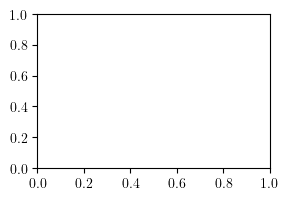

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.))

clss = allcolors[:4]
dkf = np.sqrt(m2(lamb)) / (2.*np.pi/(nLat*dx))

plt.axvline(dkf/freqmax1, color=clss[2], ls='-', label=r'$\rm Sub-Critical \; Sphaleron$')
plt.axvline(dkf/freqmax2, color=clss[3], ls=':', label=r'$\rm Precursor$')
print(freqmax1, freqmax2)

all_freqs, all_PS_oscillon, all_ind = oscillonFreqData[:,0], oscillonFreqData[:,1], oscillonFreqData[:,2]

freqs_vec = np.zeros(len(all_freqs))
for ii, ind in enumerate(all_ind):
    freqs_vec[ii] = all_freqs[ii][ind]

ah = sns.histplot(dkf/np.array(freqs_vec), color=clss[0], bins=10, 
              stat='density', edgecolor = clss[0], linewidth=0.1, label=r'$\rm Oscillons$')

# Account for characteristic Lorentz boost
print(gamma(0.29360854))
ah = sns.histplot(dkf/(np.array(freqs_vec) / gamma(0.29360854)), color=clss[1], bins=10, 
              stat='density', edgecolor = clss[1], linewidth=0.1, alpha=0.5, label=r'$\rm Accounting \; for \; boosts$')

#plt.axvline(dk*freqmax3, color='g', ls=':', label=r'$\rm Average \; Oscillon$')

avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
[plt.axvline(dkf/ii, color='k', ls='-', alpha=0.6, linewidth=0.1) for ii in avfq]

#avfq, error1 = tolerant_mean(oscillonFreqData[:,0])
#[plt.axvline(dkf/(ii / gamma(0.29360854)), color='k', ls=':', alpha=0.6, linewidth=0.1) for ii in avfq]

avfq = dkf/avfq
ax.set_xlim((avfq[2], avfq[50]))

ax.set_ylabel(r'$\rm PDF$')
ax.set_xlabel(r'$m / \omega_{\rm osc}$')
leg = ax.legend(ncol=1, loc='best', fontsize=10, bbox_to_anchor=(1.05, 0.8))

plt.savefig('./plots/characteristic_osc_frequency.pdf', dpi=500, rasterize=True)
plt.plot()
